## End to end walkthrough

Source: https://nixtlaverse.nixtla.io/mlforecast/docs/getting-started/end_to_end_walkthrough.html

In [1]:
# !pip install datasetsforecast

In [2]:
import random
import tempfile
from pathlib import Path

import pandas as pd
from datasetsforecast.m4 import M4
from utilsforecast.plotting import plot_series

### Descargar data. M4 dataset

In [3]:
await M4.async_download('data', group='Hourly')
df, *_ = M4.load('data', 'Hourly')
uids = df['unique_id'].unique()
random.seed(0)
sample_uids = random.choices(uids, k=4)
df = df[df['unique_id'].isin(sample_uids)].reset_index(drop=True)
df['ds'] = df['ds'].astype('int64')

In [4]:
df

,unique_id,ds,y
0,H196,1,11.8
1,H196,2,11.4
2,H196,3,11.1
3,H196,4,10.8
4,H196,5,10.6
...,...,...,...
4027,H413,1004,99.0
4028,H413,1005,88.0
4029,H413,1006,47.0
4030,H413,1007,41.0


### 2.EDA

In [5]:
df['unique_id'].unique() # se descarga info de 4 series

array(['H196', 'H256', 'H381', 'H413'], dtype=object)

In [6]:
# revisar el largo de cada conjunto de datos
for id in df['unique_id'].unique().tolist():
    len_serie = df[df['unique_id'] == id].shape[0]
    print(f'{id}: {len_serie}')

H196: 1008
H256: 1008
H381: 1008
H413: 1008


In [7]:
df.head(3) # son 4 series de tiempo donde se tiene el timestamp y el valor y. Todas las series tienen el mismo largo. Y no existen variables exógenas

,unique_id,ds,y
0,H196,1,11.8
1,H196,2,11.4
2,H196,3,11.1


#### Plotear para tener idea de las transformaciones y las features

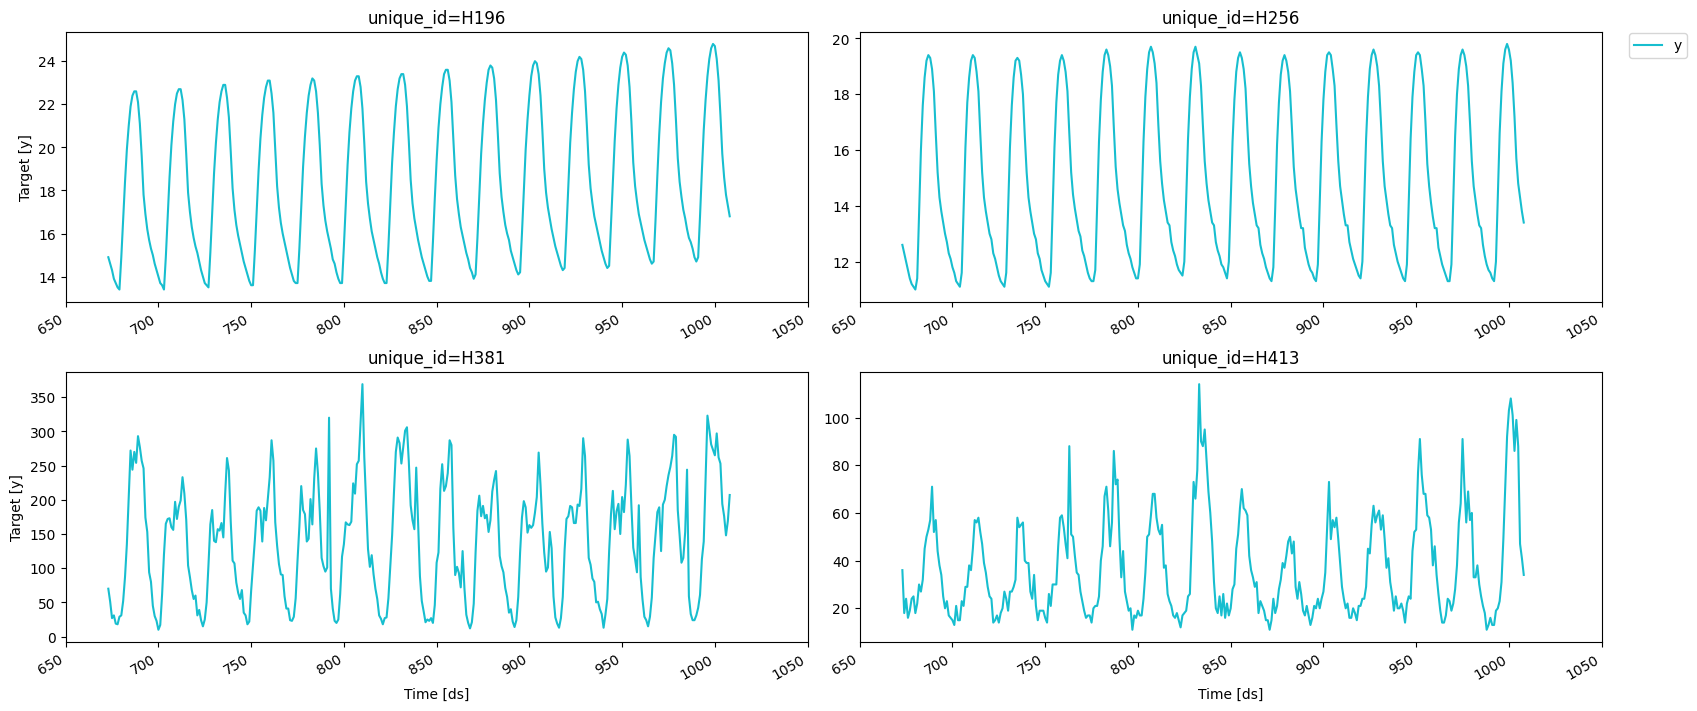

In [8]:
fig = plot_series(df, max_insample_length=24 * 14)
fig

We can use the MLForecast.preprocess method to explore different transformations. It looks like these series have a strong seasonality on the hour of the day, so we can subtract the value from the same hour in the previous day to remove it. This can be done with the mlforecast.target_transforms.Differences transformer, which we pass through target_transforms.

#### 2.1 Estacionalidad Horaria

In [9]:
## INSIGHTS DE LOS GRÁFICOS
# - ESTACIONALIDAD HORARIA (restar los valores de una hora previa para eliminarla)

In [10]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences

In [11]:
######## RESTAR EL VALOR DE LA SERIE DE UNA 1 HORA ATRÁS.

fcst = MLForecast(
    models=[],  # we're not interested in modeling yet
    freq=1,  # our series have integer timestamps, so we'll just add 1 in every timestep
    target_transforms=[Differences([24])],
)
prep = fcst.preprocess(df)
prep

,unique_id,ds,y
24,H196,25,0.3
25,H196,26,0.3
26,H196,27,0.1
27,H196,28,0.2
28,H196,29,0.2
...,...,...,...
4027,H413,1004,39.0
4028,H413,1005,55.0
4029,H413,1006,14.0
4030,H413,1007,3.0


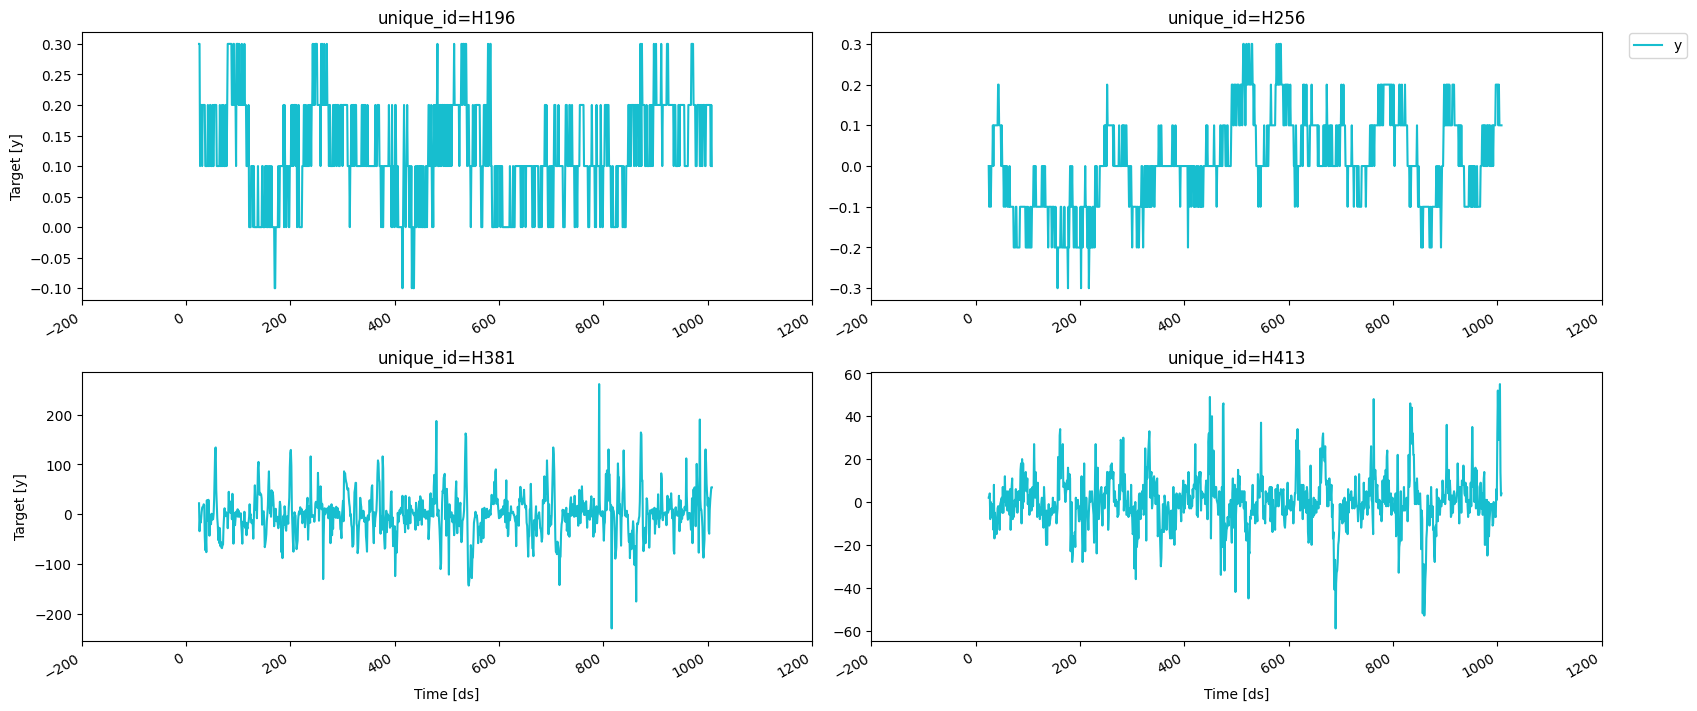

In [12]:
# volver a plotear para ver diferencia
fig = plot_series(prep)
fig

#### 2.2 Adding features

#### LAGS

Looks like the seasonality is gone, we can now try adding some lag features.

In [13]:
fcst = MLForecast(
    models=[],
    freq=1, # el timestamp es integer
    lags=[1, 24],  # NEW: agregar lags. 1 observación atrás y 24 observaciones atrás
    target_transforms=[Differences([24])],    # transformación previa, restar la estacionalidad de la serie
)

In [14]:
# se puede observar que para cada serie (identificada por el unique ID), se hace transformación y se agrega como columna feature de esa serie
prep = fcst.preprocess(df)
prep

,unique_id,ds,y,lag1,lag24
48,H196,49,0.1,0.1,0.3
49,H196,50,0.1,0.1,0.3
50,H196,51,0.2,0.1,0.1
51,H196,52,0.1,0.2,0.2
52,H196,53,0.1,0.1,0.2
...,...,...,...,...,...
4027,H413,1004,39.0,29.0,1.0
4028,H413,1005,55.0,39.0,-25.0
4029,H413,1006,14.0,55.0,-20.0
4030,H413,1007,3.0,14.0,0.0


In [15]:
# print de correlación temporal entre el target y las features (target lageado)
prep.drop(columns=['unique_id', 'ds']).corr()['y']

y        1.000000
lag1     0.622531
lag24   -0.234268
Name: y, dtype: float64

In [16]:
# se puede ver que el lag1 tiene una alta correlación (autocorrelación lag1, lo que tiene sentido al ser series de tiempo)

#### ojo: aún no aparece ninguna relación ENTRE LAS SERIES

#### Lag transforms

Lag transforms are defined as a dictionary where the keys are the lags and the values are the transformations that we want to apply to that lag. The lag transformations can be either objects from the mlforecast.lag_transforms module or numba jitted functions (so that computing the features doesn’t become a bottleneck and we can bypass the GIL when using multithreading), we have some implemented in the window-ops package but you can also implement your own.

In [17]:
# multithreading

In [18]:
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from numba import njit
from window_ops.rolling import rolling_mean

In [19]:
# forma de definir las transformaciones como funciones (cuando las transformaciones que se quieren hacer no están disponibles)
# corrobar que utilizar las funciones de nixtla y una custom que haga lo mismo dan el mismo resultado
@njit
def rolling_mean_48(x):
    return rolling_mean(x, window_size=48)

#You can see that both approaches get to the same result, you can use whichever one you feel most comfortable with.

In [20]:
fcst = MLForecast(
    models=[],
    freq=1, # timestamp es integer
    target_transforms=[Differences([24])],  # diferenciación de la serie. Seasonality horaria  
    
    # NEW agregar lag con cierta transformación en los datos
    lag_transforms={
        1: [ExpandingMean()], # NEW
        24: [RollingMean(window_size=48), rolling_mean_48], # NEW
    }
)

In [21]:
# AQUI SE PUEDE OBSERVAR QUE SI NO SE DEFINEN LOS LAGS EN LA COLUMNA LAGS, estos no se utiliza, solo se utilizan los lags con las transformaciones
prep = fcst.preprocess(df)
prep

,unique_id,ds,y,expanding_mean_lag1,rolling_mean_lag24_window_size48,rolling_mean_48_lag24
95,H196,96,0.1,0.174648,0.150000,0.150000
96,H196,97,0.3,0.173611,0.145833,0.145833
97,H196,98,0.3,0.175342,0.141667,0.141667
98,H196,99,0.3,0.177027,0.141667,0.141667
99,H196,100,0.3,0.178667,0.141667,0.141667
...,...,...,...,...,...,...
4027,H413,1004,39.0,0.242084,3.437500,3.437500
4028,H413,1005,55.0,0.281633,2.708333,2.708333
4029,H413,1006,14.0,0.337411,2.125000,2.125000
4030,H413,1007,3.0,0.351324,1.770833,1.770833


#### ojo: aún es tratamiento para la serie consigo misma y no se consideran la relaciones entre las series

#### date features
If your time column is made of timestamps then it might make sense to extract features like week, dayofweek, quarter, etc. You can do that by passing a list of strings with pandas time/date components. You can also pass functions that will take the time column as input, as we’ll show here.

In [22]:
def hour_index(times):
    return times % 24

In [23]:
fcst = MLForecast(
    models=[],
    freq=1,
    target_transforms=[Differences([24])],
    date_features=[hour_index], # NEW: aqui se llama una función para obtener la date_feature (hora, semana, dia, quarter, año, etc)
)

In [24]:
fcst.preprocess(df)

,unique_id,ds,y,hour_index
24,H196,25,0.3,1
25,H196,26,0.3,2
26,H196,27,0.1,3
27,H196,28,0.2,4
28,H196,29,0.2,5
...,...,...,...,...
4027,H413,1004,39.0,20
4028,H413,1005,55.0,21
4029,H413,1006,14.0,22
4030,H413,1007,3.0,23


#### Target transformations
If you want to do some transformation to your target before computing the features and then re-apply it after predicting you can use the target_transforms argument, which takes a list of transformations. You can find the implemented ones in mlforecast.target_transforms or you can implement your own as described in the target transformations guide.

In [25]:
from mlforecast.target_transforms import LocalStandardScaler

In [26]:
fcst = MLForecast(
    models=[],
    freq=1,
    lags=[1],
    target_transforms=[LocalStandardScaler()] # NEW. En lugar de hacer la diferenciación, se hace otra transformación al target
)

In [27]:
# SE PUEDE OBSERVAR QUE PRIMERO SE APLICA LA TRANSFORMACIÓN AL TARGET Y LUEGO SE OBTIENEN LOS LAGS
fcst.preprocess(df)

,unique_id,ds,y,lag1
1,H196,2,-1.493026,-1.383286
2,H196,3,-1.575331,-1.493026
3,H196,4,-1.657635,-1.575331
4,H196,5,-1.712505,-1.657635
5,H196,6,-1.794810,-1.712505
...,...,...,...,...
4027,H413,1004,3.062766,2.425012
4028,H413,1005,2.523128,3.062766
4029,H413,1006,0.511751,2.523128
4030,H413,1007,0.217403,0.511751


We can define a naive model to test this

In [28]:
from sklearn.base import BaseEstimator

class Naive(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return X['lag1'] # LA PREDICCIÓN ES RETORNAR EL CAMPO QUE ESTÁ DEFINIDO COMO LAG1

In [29]:
fcst = MLForecast(
    models=[Naive()],
    freq=1,
    lags=[1],
    target_transforms=[LocalStandardScaler()]
)

In [30]:
fcst.fit(df)
preds = fcst.predict(1)
preds

,unique_id,ds,Naive
0,H196,1009,16.8
1,H256,1009,13.4
2,H381,1009,207.0
3,H413,1009,34.0


In [31]:
df[df['unique_id'] == 'H196'].tail(2)

,unique_id,ds,y
1006,H196,1007,17.3
1007,H196,1008,16.8


In [32]:
# We compare this with the last values of our serie.
last_vals = df.groupby('unique_id').tail(1)
last_vals

,unique_id,ds,y
1007,H196,1008,16.8
2015,H256,1008,13.4
3023,H381,1008,207.0
4031,H413,1008,34.0


AQUI SE PUEDE OBSERVAR QUE PRIMER SE APLICA LA TRASFORMACIÓN A AL TARGET Y LUEGO LA OBTENCIÓN DE LOS LAGS Y SUS TRANSFORMACIONES
--> OJO, aun no se ve que las series estén relacionadas entre sí para hacer modelos

### 3. Training

Once you’ve decided the features, transformations and models that you want to use you can use the MLForecast.fit method instead, which will do the preprocessing and then train the models. The models can be specified as a list (which will name them by using their class name and an index if there are repeated classes) or as a dictionary where the keys are the names you want to give to the models, i.e. the name of the column that will hold their predictions, and the values are the models themselves.

In [33]:
import lightgbm as lgb

In [34]:
lgb_params = {
    'verbosity': -1,
    'num_leaves': 512,
}


In [35]:
fcst = MLForecast(
    models={
        'avg': lgb.LGBMRegressor(**lgb_params), # dar nombre al modelo
        'q75': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.75),
        'q25': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.25),
    },
    freq=1,
    target_transforms=[Differences([24])],
    lags=[1, 24], # ACÁ ESTÁ DEFINIDO LAG Y LAG TRANSFORMS. ENTONCES VAN A EXISTIR AMBAS FEATURES
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=[hour_index],
)

In [36]:
fcst.fit(df)

MLForecast(models=[avg, q75, q25], freq=1, lag_features=['lag1', 'lag24', 'expanding_mean_lag1', 'rolling_mean_lag24_window_size48'], date_features=[<function hour_index at 0x3154ffbe0>], num_threads=1)

This computed the features and trained three different models using them. We can now compute our forecasts.

In [37]:
fcst.preprocess(df).head()

,unique_id,ds,y,lag1,lag24,expanding_mean_lag1,rolling_mean_lag24_window_size48,hour_index
95,H196,96,0.1,0.2,0.2,0.174648,0.150000,0
96,H196,97,0.3,0.1,0.1,0.173611,0.145833,1
97,H196,98,0.3,0.3,0.1,0.175342,0.141667,2
98,H196,99,0.3,0.3,0.1,0.177027,0.141667,3
99,H196,100,0.3,0.3,0.2,0.178667,0.141667,4


In [38]:
fcst.models

{'avg': LGBMRegressor(num_leaves=512, verbosity=-1),
 'q75': LGBMRegressor(alpha=0.75, num_leaves=512, objective='quantile', verbosity=-1),
 'q25': LGBMRegressor(alpha=0.25, num_leaves=512, objective='quantile', verbosity=-1)}

#### AQUI TENGO LA DUDA, SI SE ENTRENA UN ÚNICO MODELO PARA LAS 4 SERIES O SE ENTRENAN UN MODELO POR SERIE
Me imagino que es un único modelo, y se pasa el índice de la serie como una feature más

In [39]:
fcst.models['avg']

LGBMRegressor(num_leaves=512, verbosity=-1)

In [40]:
# TRATAR DE OBTENER LOS MODELOS ENTRENADOS - NO FUNCIONÓ
#fcst.models['avg'].predict(fcst.preprocess(df).head())

#### Forecasting

In [41]:
preds = fcst.predict(48)
preds

,unique_id,ds,avg,q75,q25
0,H196,1009,16.295257,16.357148,16.315731
1,H196,1010,15.910282,16.007322,15.862261
2,H196,1011,15.728367,15.780183,15.658180
3,H196,1012,15.468414,15.513598,15.399717
4,H196,1013,15.081279,15.133848,15.007694
...,...,...,...,...,...
187,H413,1052,100.450617,124.211150,47.025017
188,H413,1053,88.426800,108.303409,44.715380
189,H413,1054,59.675737,81.859964,19.239462
190,H413,1055,57.580356,72.703301,21.486674


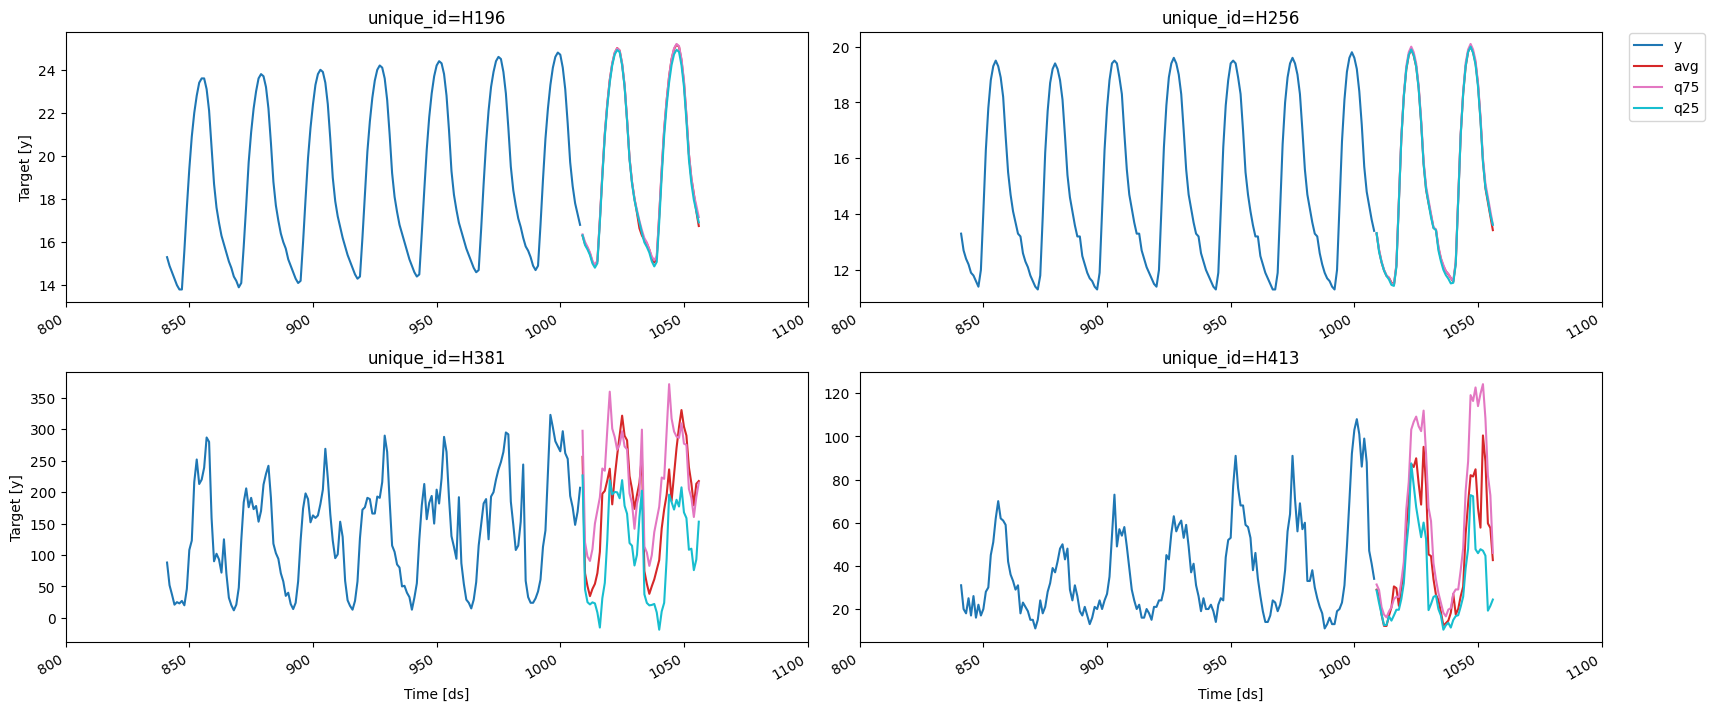

In [42]:
fig = plot_series(df, preds, max_insample_length=24 * 7)
fig

### 4. Saving and loading

The MLForecast class has the MLForecast.save and MLForecast.load to store and then load the forecast object.

In [43]:
with tempfile.TemporaryDirectory() as tmpdir:
    save_dir = Path(tmpdir) / 'mlforecast'
    fcst.save(save_dir)
    fcst2 = MLForecast.load(save_dir)
    preds2 = fcst2.predict(48)
    pd.testing.assert_frame_equal(preds, preds2)

In [44]:
# se puede ver que para guardar los modelos solo se necesita especificar una carpeta de destino. Al guardar se guarda:
# - models.pkl con los modelos
# - ts.pkl con la configuración de la clase de nixtla para ml forecast
fcst.save('models')

In [45]:
models_saved = pd.read_pickle('models/models.pkl')

In [46]:
# intento de tener una inta
try_instance = fcst.preprocess(df).tail(1)
try_instance = try_instance.drop(columns = ['y', 'ds', 'unique_id']) # eliminar las columnas que no son features

models_saved['avg'].predict(try_instance)

array([7.58935609])

### 5. Updating series’ values

After you’ve trained a forecast object you can save and load it with the previous methods. If by the time you want to use it you already know the following values of the target you can use the MLForecast.update method to incorporate these, which will allow you to use these new values when computing predictions.

If no new values are provided for a serie that’s currently stored, only the previous ones are kept.
If new series are included they are added to the existing ones.

In [47]:
## Conozco el valor real y lo agrego para que el forecast sea desde la uiltima observacion que conozco.

## ESTO SIRVE PARA LA INFERENCIA CONSTANTE CUANDO NO SE QUIERE RE-ENTRENAR EL MODELO

In [48]:
fcst = MLForecast(
    models=[Naive()],
    freq=1,
    lags=[1, 2, 3],
)
fcst.fit(df)
fcst.predict(1)

,unique_id,ds,Naive
0,H196,1009,16.8
1,H256,1009,13.4
2,H381,1009,207.0
3,H413,1009,34.0


In [49]:
new_values = pd.DataFrame({
    'unique_id': ['H196', 'H256'],
    'ds': [1009, 1009],
    'y': [17.0, 14.0],
})
fcst.update(new_values)
preds = fcst.predict(1)
preds

,unique_id,ds,Naive
0,H196,1010,17.0
1,H256,1010,14.0
2,H381,1009,207.0
3,H413,1009,34.0


### 6. Estimating model performance

https://nixtlaverse.nixtla.io/mlforecast/docs/getting-started/end_to_end_walkthrough.html#estimating-model-performance

#### Cross validation

In order to get an estimate of how well our model will be when predicting future data we can perform cross validation, which consist on training a few models independently on different subsets of the data, using them to predict a validation set and measuring their performance.

Since our data depends on time, we make our splits by removing the last portions of the series and using them as validation sets. This process is implemented in MLForecast.cross_validation.

In [50]:
fcst = MLForecast(
    models=lgb.LGBMRegressor(**lgb_params),
    freq=1,
    target_transforms=[Differences([24])],
    lags=[1, 24],
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=[hour_index],
)

In [51]:
cv_result = fcst.cross_validation(
    df,
    n_windows=4,  # number of models to train/splits to perform
    h=48,  # length of the validation set in each window
)
cv_result

,unique_id,ds,cutoff,y,LGBMRegressor
0,H196,817,816,15.3,15.383165
1,H196,818,816,14.9,14.923219
2,H196,819,816,14.6,14.667834
3,H196,820,816,14.2,14.275964
4,H196,821,816,13.9,13.973491
...,...,...,...,...,...
763,H413,1004,960,99.0,65.644823
764,H413,1005,960,88.0,71.717097
765,H413,1006,960,47.0,76.704377
766,H413,1007,960,41.0,53.446638


In [52]:
48 * 4

192

In [53]:
cv_result['cutoff'].unique() # las predicciones entrenando modelos en los 4 diferentes conjutnos de datos, con diferentes cutoff

array([816, 864, 912, 960])

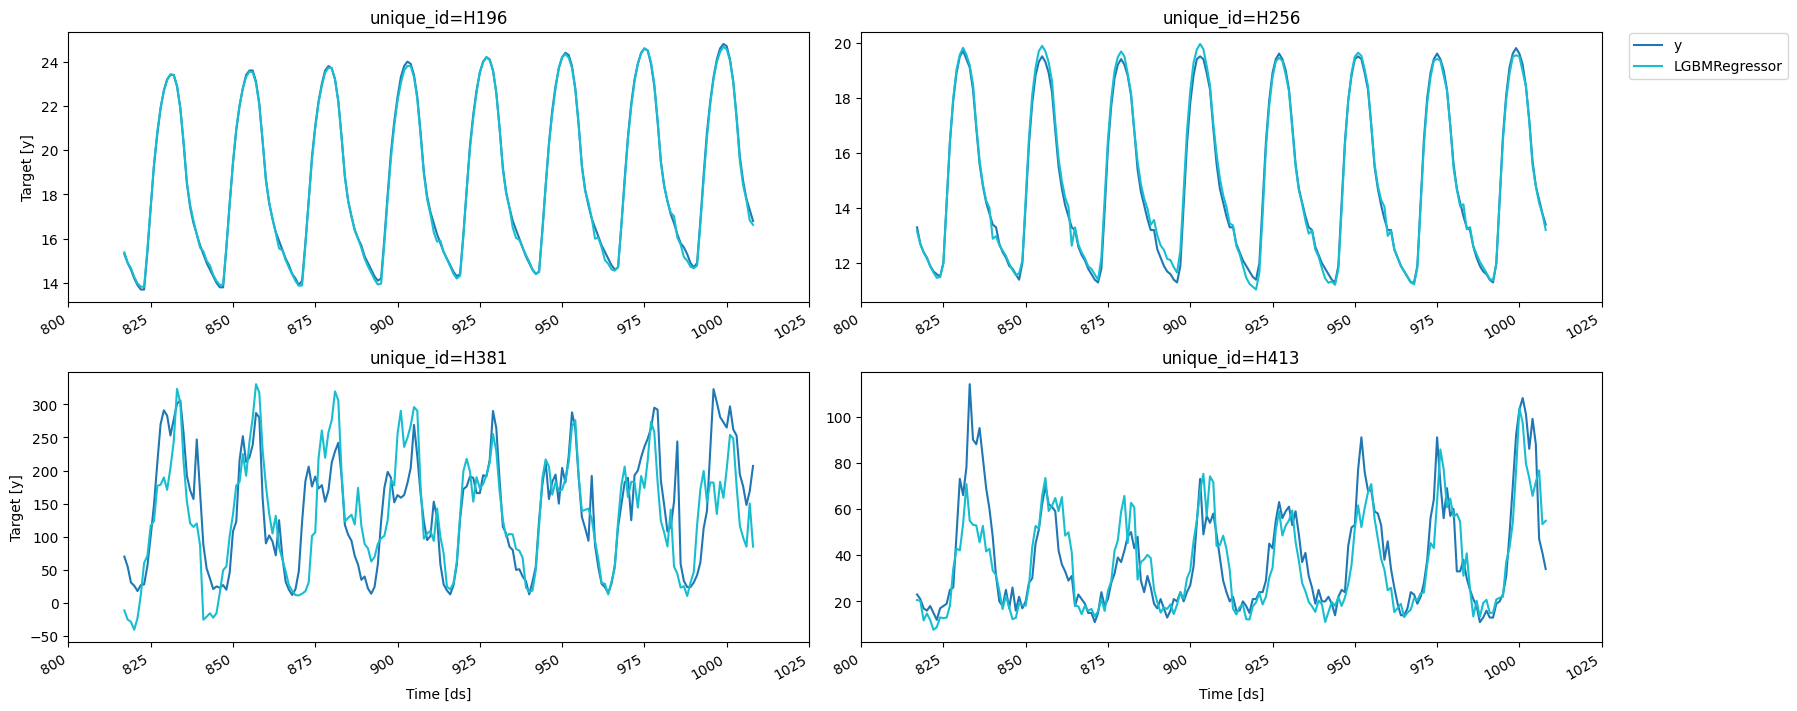

In [54]:
fig = plot_series(forecasts_df=cv_result.drop(columns='cutoff'))
fig

### Compare r2

In [55]:
from utilsforecast.losses import rmse

In [56]:
def evaluate_cv(df):
    return rmse(df, models=['LGBMRegressor'], id_col='cutoff').set_index('cutoff')

split_rmse = evaluate_cv(cv_result)
split_rmse

,LGBMRegressor
cutoff,
816,29.418172
864,34.257598
912,13.145763
960,35.066261


In [57]:
# And the average RMSE across splits.
split_rmse.mean()

LGBMRegressor    27.971949
dtype: float64

**You can quickly try different features and evaluate them this way. We can try removing the differencing and using an exponentially weighted average of the lag 1 instead of the expanding mean.**

In [58]:
from mlforecast.lag_transforms import ExponentiallyWeightedMean

In [59]:
# ahora entrenar otro modelo y hacer cv.
# me imagino que la idea es ver cómo se comporta la métrica usando diferentes subconjuntos y encontrar el mejor modelo
fcst = MLForecast(
    models=lgb.LGBMRegressor(**lgb_params),
    freq=1,
    lags=[1, 24],
    lag_transforms={
        1: [ExponentiallyWeightedMean(alpha=0.5)],
        24: [RollingMean(window_size=48)],      
    },
    date_features=[hour_index],    
)

In [60]:
cv_result2 = fcst.cross_validation(
    df,
    n_windows=4,
    h=48,
)
evaluate_cv(cv_result2).mean()

LGBMRegressor    25.874439
dtype: float64

#### LightGBMCV

In the same spirit of estimating our model’s performance, LightGBMCV allows us to train a few LightGBM models on different partitions of the data. The main differences with MLForecast.cross_validation are:

- It can only train LightGBM models.

- It trains all models simultaneously and gives us per-iteration averages of the errors across the complete forecasting window, which allows us to find the best iteration.

In [61]:
from mlforecast.lgb_cv import LightGBMCV

In [62]:
cv = LightGBMCV(
    freq=1,
    target_transforms=[Differences([24])],
    lags=[1, 24],
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=[hour_index],
    num_threads=2,
)

In [63]:
cv

LightGBMCV(freq=1, lag_features=['lag1', 'lag24', 'expanding_mean_lag1', 'rolling_mean_lag24_window_size48'], date_features=[<function hour_index at 0x3154ffbe0>], num_threads=2, bst_threads=6)

In [64]:
cv_hist = cv.fit(
    df,
    n_windows=4,
    h=48,
    params=lgb_params,
    eval_every=5,
    early_stopping_evals=5,    
    compute_cv_preds=True,
)

[5] mape: 0.158639
[10] mape: 0.163739
[15] mape: 0.161535
[20] mape: 0.169491
[25] mape: 0.163690
[30] mape: 0.164198
Early stopping at round 30
Using best iteration: 5


As you can see this gives us the error by iteration (controlled by the eval_every argument) and performs early stopping (which can be configured with early_stopping_evals and early_stopping_pct). If you set compute_cv_preds=True the out-of-fold predictions are computed using the best iteration found and are saved in the cv_preds_ attribute.

In [65]:
cv.cv_preds_

,unique_id,ds,y,Booster,window
0,H196,817,15.3,15.473182,0
1,H196,818,14.9,15.038571,0
2,H196,819,14.6,14.849409,0
3,H196,820,14.2,14.448379,0
4,H196,821,13.9,14.148379,0
...,...,...,...,...,...
187,H413,1004,99.0,61.425396,3
188,H413,1005,88.0,62.886890,3
189,H413,1006,47.0,57.886890,3
190,H413,1007,41.0,38.849009,3


You can use this class to quickly try different configurations of features and hyperparameters. Once you’ve found a combination that works you can train a model with those features and hyperparameters on all the data by creating an MLForecast object from the LightGBMCV one as follows:

In [66]:
final_fcst = MLForecast.from_cv(cv)
final_fcst.fit(df)
preds = final_fcst.predict(48)
fig = plot_series(df, preds, max_insample_length=24 * 14)

In [67]:
final_fcst.models['LGBMRegressor']

LGBMRegressor(n_estimators=5, num_leaves=512, verbosity=-1)